# KADEM Hocine
# BENAHMED Neil

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video
import torch.nn as nn
import gymnasium as gym
from bbrl.utils.chrono import Chrono
import matplotlib
import matplotlib.pyplot as plt
from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")
import gymnasium as gym
import tools
from scipy.stats import ttest_ind

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)

# Naive actor critic algorithm Function

In [22]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm with entropy and convergence tracking.
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories, entropies, convergence_steps
    """
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []
    entropies = []  # List to track entropy
    convergence_steps = 0

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False
        entropy_episode = 0

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            a = sample_categorical(pi[s, :])
            s_next, r, terminated, truncated, _ = env.step(a)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]
            V[s] = V[s] + alpha_critic * delta

            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Calculate entropy for current state
            entropy_episode += -np.sum(pi[s, :] * np.log(pi[s, :] + 1e-8))

            s = s_next
            cpt += 1

        trajectories.append(cpt)
        entropies.append(entropy_episode)  # Store entropy for this episode

        # Check for convergence (e.g., policy does not change significantly)
        if episode > 1 and np.allclose(pi, previous_pi, atol=1e-3):
            convergence_steps = episode
            break

        previous_pi = pi.copy()

    return pi, V, trajectories, entropies, convergence_steps


### Actor-critic hyper-parameters

In [23]:
# Define global constants 
NB_EPISODES = 400

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",  # "human" to render the maze OR "rgb_array"
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.9,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

# # Base actor-critic parameters
# AC_PARAMS = {
#     'nb_episodes': NB_EPISODES,
#     'timeout': 50,
#     'gamma': 0.99,
#     'mdp': {
#         'width': 5,
#         'height': 5,
#         'ratio': 0.2,
#         'render_mode': "humain",
#     },
#     "alpha_critic": 0.5,
#     "alpha_actor": 0.5,
# }

### Run multiple experiments

In [24]:
AC_PARAMS['mdp']['render_mode'] = "human"
env = tools.create_maze_from_params(AC_PARAMS)

alpha_actor = AC_PARAMS['alpha_actor']
alpha_critic = AC_PARAMS['alpha_critic']
gamma = AC_PARAMS['alpha_critic'] 
nb_episodes = AC_PARAMS['nb_episodes']
timeout = AC_PARAMS['timeout']
 

pi, V_per_episode, trajectories, entropies, rewards_per_episode, deltas = tools.naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=True
        )

       [ 1,  6, -1, 13, 17],
       [ 2, -1, 10, …

In [25]:
%matplotlib inline
AC_PARAMS['mdp']["render_mode"] = "rgb_array"
n_runs = 5
# Run multiple experiments and gather results
all_values, all_trajectories, all_entropies, all_rewards, all_deltas = tools.run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

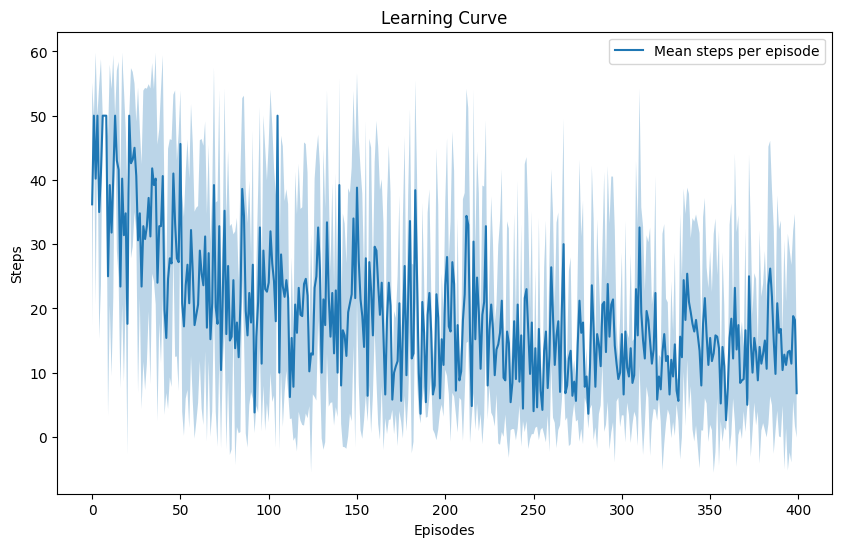

In [26]:
def plot_learning_curve(all_trajectories, plot_name=''):
    # Calculate mean and std for trajectories, assuming they are of different lengths
    max_len = max(map(len, all_trajectories))
    
    # Convert trajectories to arrays of floats and pad with NaN
    padded_trajectories = np.array([np.pad(np.array(t, dtype=float), (0, max_len - len(t)), 'constant', constant_values=np.nan) for t in all_trajectories])
    
    # Calculate mean and std, ignoring NaNs
    mean_trajectories = np.nanmean(padded_trajectories, axis=0)
    std_trajectories = np.nanstd(padded_trajectories, axis=0)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_trajectories, label='Mean steps per episode')
    plt.fill_between(range(len(mean_trajectories)), mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, alpha=0.3)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(plot_name)
    plt.legend()
    plt.show()

# Plot the learning curve with the updated function
plot_learning_curve(all_trajectories,'Learning Curve')

# Perform hyper-parameters tuning

## Set up the basic parameters and optimization criteria

In this first step, we define the base parameters for the optimization process, such as the search space for alpha_actor and alpha_critic, the samplers (search strategies), and store the optimization results.

In [27]:
# Total number of trials and the number of values for each hyperparameter
n_trials = 300  # Chosen for sufficient exploration of the search space

# The number of independent runs per trial to average results and reduce variability.
n_runs = 5  # Ensures stability of results across multiple runs

# The number of episodes per trial
nb_episodes = 400  # Chosen for enough training time per trial

In [28]:
from optuna.samplers import TPESampler, RandomSampler, NSGAIISampler, GridSampler

n_values = int(np.sqrt(n_trials))  # Ensure that the number of values matches the total number of trials

# Search space for alpha_actor and alpha_critic (logarithmic scale)
SEARCH_SPACE = {
    "alpha_actor": np.logspace(-1, 0, n_values).tolist(),  # From 1e-3 to 1.0 with n_values points
    "alpha_critic": np.logspace(-1, 0, n_values).tolist()  # Same range for alpha_critic
}

# List of samplers to evaluate
SAMPLERS = {
    "Grid Search": GridSampler(SEARCH_SPACE),
    "Random Search": RandomSampler(),
    "TPE (Bayesian Optimization)": TPESampler(),
    "NSGA-II": NSGAIISampler()
}

# Dictionary to store the results
results = {}

# Base actor-critic parameters
AC_PARAMS = {
    'nb_episodes': nb_episodes,
    'timeout': 50,
    'gamma': 0.8,
    'mdp': {
        'width': 5,
        'height': 5,
        'ratio': 0.2,
        'render_mode': None
    }
}

## Define the optimization loop for each criterion

In [29]:
# Define the optimization criteria
criteria = ['value_norm', 'convergence_time', 'cumulative_reward', 'discounted_cumulative_reward', 'temporal_difference_error']  

# Loop through each criterion
for criterion in criteria:
    print(f"Optimizing for criterion: {criterion}...")

    # For each criterion, we will loop through the samplers
    for sampler_name, sampler in SAMPLERS.items():
        print(f"Running optimization with {sampler_name}...")

        # Run optimization using the current criterion
        study, best_params, best_performance, all_params, value_norms, trajectories, cumulative_rewards, deltas = tools.run_optimization(
            ac_params=AC_PARAMS,
            sampler=sampler,
            n_trials=n_trials,  
            n_runs=n_runs, 
            criterion=criterion  # Optimization based on the selected criterion
        )

        # Store the results for each sampler
        results[f"{criterion}_{sampler_name}"] = {
            "study": study,
            "best_params": best_params,
            "best_performance": best_performance,
            "all_params": all_params,
            "value_norms": value_norms,
            "trajectories": trajectories,
            "cumulative_rewards": cumulative_rewards,
            "temporal_difference_error" : deltas
        }

        print(f"Best performance for {criterion} using {sampler_name}: {best_performance}")

[I 2024-10-04 22:22:21,788] A new study created in memory with name: no-name-f25398aa-0dde-4a39-9849-405c2934c4e2


Optimizing for criterion: value_norm...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 22:22:22,165] Trial 0 finished with value: -10.707202467258895 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: -10.707202467258895.
[I 2024-10-04 22:22:22,457] Trial 1 finished with value: -10.81150828239884 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -10.81150828239884.
[I 2024-10-04 22:22:22,788] Trial 2 finished with value: -11.394981633656915 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 2 with value: -11.394981633656915.
[I 2024-10-04 22:22:23,166] Trial 3 finished with value: -10.034083866541913 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 2 with value: -11.394981633656915.
[I 2024-10-04 22:22:23,489] Trial 4 finished with value: -10.065603200483768 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_criti

Best performance for value_norm using Grid Search: -12.251298119748046
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 22:24:07,046] Trial 0 finished with value: -10.50182028490708 and parameters: {'alpha_actor': 0.9496130692859942, 'alpha_critic': 0.9778247092935427}. Best is trial 0 with value: -10.50182028490708.
[I 2024-10-04 22:24:07,337] Trial 1 finished with value: -10.854486704419378 and parameters: {'alpha_actor': 0.972631928136521, 'alpha_critic': 0.9081630604211792}. Best is trial 1 with value: -10.854486704419378.
[I 2024-10-04 22:24:07,743] Trial 2 finished with value: -9.15514113358916 and parameters: {'alpha_actor': 0.3846309442817133, 'alpha_critic': 0.9980126850925003}. Best is trial 1 with value: -10.854486704419378.
[I 2024-10-04 22:24:08,084] Trial 3 finished with value: -10.414784006067324 and parameters: {'alpha_actor': 0.8018679717358468, 'alpha_critic': 0.18168139466856476}. Best is trial 1 with value: -10.854486704419378.
[I 2024-10-04 22:24:08,643] Trial 4 finished with value: -9.07348566245529 and parameters: {'alpha_actor': 0.7065405671470798, 'alpha_critic': 0

Best performance for value_norm using Random Search: -12.490992413612641
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 22:25:44,512] Trial 0 finished with value: -9.072529011671355 and parameters: {'alpha_actor': 0.1099366027038207, 'alpha_critic': 0.6284804299344663}. Best is trial 0 with value: -9.072529011671355.
[I 2024-10-04 22:25:44,787] Trial 1 finished with value: -11.618249756181127 and parameters: {'alpha_actor': 0.5314177002550001, 'alpha_critic': 0.6726080682418195}. Best is trial 1 with value: -11.618249756181127.
[I 2024-10-04 22:25:45,130] Trial 2 finished with value: -10.760862173697413 and parameters: {'alpha_actor': 0.24145762830515147, 'alpha_critic': 0.2835161664885167}. Best is trial 1 with value: -11.618249756181127.
[I 2024-10-04 22:25:45,501] Trial 3 finished with value: -11.30369967785052 and parameters: {'alpha_actor': 0.11770465958348061, 'alpha_critic': 0.5117955759845765}. Best is trial 1 with value: -11.618249756181127.
[I 2024-10-04 22:25:45,900] Trial 4 finished with value: -9.940918918444309 and parameters: {'alpha_actor': 0.5749353609105033, 'alpha_critic

Best performance for value_norm using TPE (Bayesian Optimization): -12.440854656976843
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 22:27:16,728] Trial 0 finished with value: -10.500777774762444 and parameters: {'alpha_actor': 0.541631278821098, 'alpha_critic': 0.15914154654911172}. Best is trial 0 with value: -10.500777774762444.
[I 2024-10-04 22:27:17,064] Trial 1 finished with value: -10.10628698540566 and parameters: {'alpha_actor': 0.5133402959154025, 'alpha_critic': 0.5995693090300829}. Best is trial 0 with value: -10.500777774762444.
[I 2024-10-04 22:27:17,354] Trial 2 finished with value: -10.55594144144301 and parameters: {'alpha_actor': 0.616570635278878, 'alpha_critic': 0.5833747668664119}. Best is trial 2 with value: -10.55594144144301.
[I 2024-10-04 22:27:17,609] Trial 3 finished with value: -11.575868322332866 and parameters: {'alpha_actor': 0.5051967233907936, 'alpha_critic': 0.5958614672076218}. Best is trial 3 with value: -11.575868322332866.
[I 2024-10-04 22:27:17,884] Trial 4 finished with value: -11.509755615431052 and parameters: {'alpha_actor': 0.3961313923514097, 'alpha_critic':

Best performance for value_norm using NSGA-II: -12.383557709884647
Optimizing for criterion: convergence_time...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 22:28:52,143] Trial 0 finished with value: 12.764000000000001 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: 12.764000000000001.
[I 2024-10-04 22:28:52,445] Trial 1 finished with value: 7.991499999999999 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: 7.991499999999999.
[I 2024-10-04 22:28:52,810] Trial 2 finished with value: 9.965000000000002 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: 7.991499999999999.
[I 2024-10-04 22:28:53,138] Trial 3 finished with value: 9.031500000000001 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: 7.991499999999999.
[I 2024-10-04 22:28:53,447] Trial 4 finished with value: 7.921500000000001 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0.23713737

Best performance for convergence_time using Grid Search: 5.316
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 22:30:42,121] Trial 0 finished with value: 7.6645 and parameters: {'alpha_actor': 0.5280236179904694, 'alpha_critic': 0.18881812358169092}. Best is trial 0 with value: 7.6645.
[I 2024-10-04 22:30:42,429] Trial 1 finished with value: 8.2905 and parameters: {'alpha_actor': 0.7190255918435898, 'alpha_critic': 0.8564272663737235}. Best is trial 0 with value: 7.6645.
[I 2024-10-04 22:30:42,765] Trial 2 finished with value: 9.7445 and parameters: {'alpha_actor': 0.15695707649633142, 'alpha_critic': 0.803805614785594}. Best is trial 0 with value: 7.6645.
[I 2024-10-04 22:30:43,057] Trial 3 finished with value: 8.367 and parameters: {'alpha_actor': 0.5878077157227289, 'alpha_critic': 0.22076097472472928}. Best is trial 0 with value: 7.6645.
[I 2024-10-04 22:30:43,332] Trial 4 finished with value: 7.6285 and parameters: {'alpha_actor': 0.8704470415183007, 'alpha_critic': 0.12689125229358802}. Best is trial 4 with value: 7.6285.
[I 2024-10-04 22:30:43,622] Trial 5 finished with val

Best performance for convergence_time using Random Search: 5.6725
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 22:32:17,364] Trial 0 finished with value: 11.570500000000003 and parameters: {'alpha_actor': 0.8007813850456287, 'alpha_critic': 0.6608507081337159}. Best is trial 0 with value: 11.570500000000003.
[I 2024-10-04 22:32:17,742] Trial 1 finished with value: 10.128499999999999 and parameters: {'alpha_actor': 0.7876685093458079, 'alpha_critic': 0.4580389140651143}. Best is trial 1 with value: 10.128499999999999.
[I 2024-10-04 22:32:18,084] Trial 2 finished with value: 9.2075 and parameters: {'alpha_actor': 0.24317589281983978, 'alpha_critic': 0.6187485449304886}. Best is trial 2 with value: 9.2075.
[I 2024-10-04 22:32:18,359] Trial 3 finished with value: 7.1575 and parameters: {'alpha_actor': 0.8153845778802443, 'alpha_critic': 0.14444200789324924}. Best is trial 3 with value: 7.1575.
[I 2024-10-04 22:32:18,586] Trial 4 finished with value: 5.763 and parameters: {'alpha_actor': 0.8812729172264466, 'alpha_critic': 0.23880535039640127}. Best is trial 4 with value: 5.763.
[I 202

Best performance for convergence_time using TPE (Bayesian Optimization): 5.3660000000000005
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 22:33:45,577] Trial 0 finished with value: 7.6745 and parameters: {'alpha_actor': 0.5744054137481881, 'alpha_critic': 0.263085175260095}. Best is trial 0 with value: 7.6745.
[I 2024-10-04 22:33:45,867] Trial 1 finished with value: 8.0855 and parameters: {'alpha_actor': 0.8821944620010108, 'alpha_critic': 0.3644189942373569}. Best is trial 0 with value: 7.6745.
[I 2024-10-04 22:33:46,108] Trial 2 finished with value: 6.332000000000001 and parameters: {'alpha_actor': 0.8064727383430972, 'alpha_critic': 0.9319235340366957}. Best is trial 2 with value: 6.332000000000001.
[I 2024-10-04 22:33:46,359] Trial 3 finished with value: 6.580500000000001 and parameters: {'alpha_actor': 0.9693891706115384, 'alpha_critic': 0.7561806291854141}. Best is trial 2 with value: 6.332000000000001.
[I 2024-10-04 22:33:46,606] Trial 4 finished with value: 6.6095 and parameters: {'alpha_actor': 0.8451190984810109, 'alpha_critic': 0.8179603176469806}. Best is trial 2 with value: 6.332000000000001.
[

Best performance for convergence_time using NSGA-II: 5.704
Optimizing for criterion: cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 22:35:18,192] Trial 0 finished with value: -379.6 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: -379.6.
[I 2024-10-04 22:35:18,568] Trial 1 finished with value: -382.4 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -382.4.
[I 2024-10-04 22:35:18,901] Trial 2 finished with value: -389.6 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 2 with value: -389.6.
[I 2024-10-04 22:35:19,253] Trial 3 finished with value: -383.4 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 2 with value: -389.6.
[I 2024-10-04 22:35:19,545] Trial 4 finished with value: -387.8 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0.23713737056616552}. Best is trial 2 with value: -389.6.
[I 2024-10-04 22:35:20,281] Trial 5 finished with val

Best performance for cumulative_reward using Grid Search: -397.0
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 22:37:02,965] Trial 0 finished with value: -391.4 and parameters: {'alpha_actor': 0.946794856067607, 'alpha_critic': 0.1355952075008443}. Best is trial 0 with value: -391.4.
[I 2024-10-04 22:37:03,281] Trial 1 finished with value: -383.6 and parameters: {'alpha_actor': 0.977644855694033, 'alpha_critic': 0.9713668319163873}. Best is trial 0 with value: -391.4.
[I 2024-10-04 22:37:03,627] Trial 2 finished with value: -385.4 and parameters: {'alpha_actor': 0.15209097943184197, 'alpha_critic': 0.3412351995797718}. Best is trial 0 with value: -391.4.
[I 2024-10-04 22:37:03,950] Trial 3 finished with value: -380.4 and parameters: {'alpha_actor': 0.5247252796091768, 'alpha_critic': 0.5799732519490465}. Best is trial 0 with value: -391.4.
[I 2024-10-04 22:37:04,244] Trial 4 finished with value: -385.4 and parameters: {'alpha_actor': 0.7154648592220403, 'alpha_critic': 0.13370132463696408}. Best is trial 0 with value: -391.4.
[I 2024-10-04 22:37:04,489] Trial 5 finished with value

Best performance for cumulative_reward using Random Search: -397.6
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 22:38:39,203] Trial 0 finished with value: -379.0 and parameters: {'alpha_actor': 0.2752253697779731, 'alpha_critic': 0.37278956624854}. Best is trial 0 with value: -379.0.
[I 2024-10-04 22:38:39,492] Trial 1 finished with value: -390.0 and parameters: {'alpha_actor': 0.2357548813368234, 'alpha_critic': 0.45300079232953594}. Best is trial 1 with value: -390.0.
[I 2024-10-04 22:38:39,853] Trial 2 finished with value: -383.2 and parameters: {'alpha_actor': 0.4956556731677283, 'alpha_critic': 0.8501787374428652}. Best is trial 1 with value: -390.0.
[I 2024-10-04 22:38:40,178] Trial 3 finished with value: -390.0 and parameters: {'alpha_actor': 0.846495586313274, 'alpha_critic': 0.7187766138026823}. Best is trial 1 with value: -390.0.
[I 2024-10-04 22:38:40,493] Trial 4 finished with value: -391.6 and parameters: {'alpha_actor': 0.3484228107674958, 'alpha_critic': 0.6890112278378644}. Best is trial 4 with value: -391.6.
[I 2024-10-04 22:38:40,915] Trial 5 finished with value: 

Best performance for cumulative_reward using TPE (Bayesian Optimization): -398.2
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 22:40:09,056] Trial 0 finished with value: -375.2 and parameters: {'alpha_actor': 0.9823535714177972, 'alpha_critic': 0.18403599988061786}. Best is trial 0 with value: -375.2.
[I 2024-10-04 22:40:09,335] Trial 1 finished with value: -391.2 and parameters: {'alpha_actor': 0.4811718552167762, 'alpha_critic': 0.9012536379320293}. Best is trial 1 with value: -391.2.
[I 2024-10-04 22:40:09,811] Trial 2 finished with value: -368.4 and parameters: {'alpha_actor': 0.12350674270747325, 'alpha_critic': 0.7350452991393897}. Best is trial 1 with value: -391.2.
[I 2024-10-04 22:40:10,150] Trial 3 finished with value: -388.4 and parameters: {'alpha_actor': 0.6430426986696114, 'alpha_critic': 0.524302144502088}. Best is trial 1 with value: -391.2.
[I 2024-10-04 22:40:10,418] Trial 4 finished with value: -392.4 and parameters: {'alpha_actor': 0.9057405909605684, 'alpha_critic': 0.5923099357910669}. Best is trial 4 with value: -392.4.
[I 2024-10-04 22:40:10,800] Trial 5 finished with valu

Best performance for cumulative_reward using NSGA-II: -397.8
Optimizing for criterion: discounted_cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 22:41:38,997] Trial 0 finished with value: -2.668538068052338 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: -2.668538068052338.
[I 2024-10-04 22:41:39,255] Trial 1 finished with value: -3.232733567776544 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -3.232733567776544.
[I 2024-10-04 22:41:39,643] Trial 2 finished with value: -1.6153632525196673 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: -3.232733567776544.
[I 2024-10-04 22:41:39,900] Trial 3 finished with value: -3.1256356735052626 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: -3.232733567776544.
[I 2024-10-04 22:41:40,189] Trial 4 finished with value: -1.8460715055612809 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 

Best performance for discounted_cumulative_reward using Grid Search: -4.224484130816
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 22:43:24,731] Trial 0 finished with value: -2.3508475531700794 and parameters: {'alpha_actor': 0.6536191383707141, 'alpha_critic': 0.19241537154817445}. Best is trial 0 with value: -2.3508475531700794.
[I 2024-10-04 22:43:25,007] Trial 1 finished with value: -2.9876867893292407 and parameters: {'alpha_actor': 0.41899593898892296, 'alpha_critic': 0.7846655884949905}. Best is trial 1 with value: -2.9876867893292407.
[I 2024-10-04 22:43:25,277] Trial 2 finished with value: -3.089864271595136 and parameters: {'alpha_actor': 0.31112244204296513, 'alpha_critic': 0.7490830976190044}. Best is trial 2 with value: -3.089864271595136.
[I 2024-10-04 22:43:25,687] Trial 3 finished with value: -1.0284549323751382 and parameters: {'alpha_actor': 0.8269406334321528, 'alpha_critic': 0.31161018372259824}. Best is trial 2 with value: -3.089864271595136.
[I 2024-10-04 22:43:25,939] Trial 4 finished with value: -2.5060159825892114 and parameters: {'alpha_actor': 0.9511278866402337, 'alpha_cri

Best performance for discounted_cumulative_reward using Random Search: -4.145375727347391
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 22:45:00,995] Trial 0 finished with value: -2.224388813442268 and parameters: {'alpha_actor': 0.44919420476866656, 'alpha_critic': 0.9690895855351673}. Best is trial 0 with value: -2.224388813442268.
[I 2024-10-04 22:45:01,355] Trial 1 finished with value: -1.7679090560511277 and parameters: {'alpha_actor': 0.3047270974869316, 'alpha_critic': 0.22077867002928833}. Best is trial 0 with value: -2.224388813442268.
[I 2024-10-04 22:45:01,877] Trial 2 finished with value: -2.390085990950759 and parameters: {'alpha_actor': 0.13534368455493356, 'alpha_critic': 0.5174007756170452}. Best is trial 2 with value: -2.390085990950759.
[I 2024-10-04 22:45:02,145] Trial 3 finished with value: -2.6886013610669433 and parameters: {'alpha_actor': 0.6391166717899198, 'alpha_critic': 0.32836659018980063}. Best is trial 3 with value: -2.6886013610669433.
[I 2024-10-04 22:45:02,450] Trial 4 finished with value: -1.6415387268750248 and parameters: {'alpha_actor': 0.7769313268424066, 'alpha_criti

Best performance for discounted_cumulative_reward using TPE (Bayesian Optimization): -4.359538521298719
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 22:46:33,147] Trial 0 finished with value: -1.8993139005733386 and parameters: {'alpha_actor': 0.7572497408935294, 'alpha_critic': 0.7193073444208582}. Best is trial 0 with value: -1.8993139005733386.
[I 2024-10-04 22:46:33,383] Trial 1 finished with value: -3.318929691339842 and parameters: {'alpha_actor': 0.8011796340178569, 'alpha_critic': 0.7896782834837376}. Best is trial 1 with value: -3.318929691339842.
[I 2024-10-04 22:46:33,701] Trial 2 finished with value: -1.9675877724945052 and parameters: {'alpha_actor': 0.4794443288788919, 'alpha_critic': 0.9452893880665956}. Best is trial 1 with value: -3.318929691339842.
[I 2024-10-04 22:46:33,976] Trial 3 finished with value: -3.1268729261989128 and parameters: {'alpha_actor': 0.7562261571954964, 'alpha_critic': 0.6364532279657624}. Best is trial 1 with value: -3.318929691339842.
[I 2024-10-04 22:46:34,330] Trial 4 finished with value: -2.320572736984737 and parameters: {'alpha_actor': 0.18432902869240347, 'alpha_critic':

Best performance for discounted_cumulative_reward using NSGA-II: -4.1681584584203435
Optimizing for criterion: temporal_difference_error...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 22:48:05,414] Trial 0 finished with value: 0.3236463887463293 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: 0.3236463887463293.
[I 2024-10-04 22:48:05,654] Trial 1 finished with value: 0.1638604817888892 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: 0.1638604817888892.
[I 2024-10-04 22:48:05,964] Trial 2 finished with value: 0.25457295905815025 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: 0.1638604817888892.
[I 2024-10-04 22:48:06,287] Trial 3 finished with value: 0.16540972221862352 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: 0.1638604817888892.
[I 2024-10-04 22:48:06,658] Trial 4 finished with value: 0.12057556205878296 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 

Best performance for temporal_difference_error using Grid Search: 0.09146185035115934
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 22:49:50,797] Trial 0 finished with value: 0.15554200744396832 and parameters: {'alpha_actor': 0.4617652862585858, 'alpha_critic': 0.5562672525781635}. Best is trial 0 with value: 0.15554200744396832.
[I 2024-10-04 22:49:51,057] Trial 1 finished with value: 0.14157489900399844 and parameters: {'alpha_actor': 0.6036782225808848, 'alpha_critic': 0.8810514597193236}. Best is trial 1 with value: 0.14157489900399844.
[I 2024-10-04 22:49:51,335] Trial 2 finished with value: 0.20313999121805146 and parameters: {'alpha_actor': 0.3467348037116811, 'alpha_critic': 0.7715930310676887}. Best is trial 1 with value: 0.14157489900399844.
[I 2024-10-04 22:49:51,584] Trial 3 finished with value: 0.10743967131996367 and parameters: {'alpha_actor': 0.8748754958774837, 'alpha_critic': 0.7708605761711362}. Best is trial 3 with value: 0.10743967131996367.
[I 2024-10-04 22:49:51,861] Trial 4 finished with value: 0.2805322435156771 and parameters: {'alpha_actor': 0.2512182283726807, 'alpha_criti

Best performance for temporal_difference_error using Random Search: 0.08951199027854177
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 22:51:26,446] Trial 0 finished with value: 0.13536225474254127 and parameters: {'alpha_actor': 0.5336544068061561, 'alpha_critic': 0.40373306528536934}. Best is trial 0 with value: 0.13536225474254127.
[I 2024-10-04 22:51:26,770] Trial 1 finished with value: 0.23963226537983018 and parameters: {'alpha_actor': 0.27965971880387164, 'alpha_critic': 0.9522009744052233}. Best is trial 0 with value: 0.13536225474254127.
[I 2024-10-04 22:51:27,090] Trial 2 finished with value: 0.13769111473505696 and parameters: {'alpha_actor': 0.8227649728923995, 'alpha_critic': 0.21090344410437922}. Best is trial 0 with value: 0.13536225474254127.
[I 2024-10-04 22:51:27,437] Trial 3 finished with value: 0.19740993076082444 and parameters: {'alpha_actor': 0.2866218596263458, 'alpha_critic': 0.4527613188518408}. Best is trial 0 with value: 0.13536225474254127.
[I 2024-10-04 22:51:27,777] Trial 4 finished with value: 0.08708368415189122 and parameters: {'alpha_actor': 0.9645234764737077, 'alpha_c

Best performance for temporal_difference_error using TPE (Bayesian Optimization): 0.0820704758859745
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 22:52:52,847] Trial 0 finished with value: 0.20487181472362984 and parameters: {'alpha_actor': 0.40904157782884265, 'alpha_critic': 0.17702249171219575}. Best is trial 0 with value: 0.20487181472362984.
[I 2024-10-04 22:52:53,181] Trial 1 finished with value: 0.222679282619499 and parameters: {'alpha_actor': 0.9138453944258866, 'alpha_critic': 0.10051112787309117}. Best is trial 0 with value: 0.20487181472362984.
[I 2024-10-04 22:52:53,504] Trial 2 finished with value: 0.18436378449731464 and parameters: {'alpha_actor': 0.3321620481823965, 'alpha_critic': 0.49391048772894786}. Best is trial 2 with value: 0.18436378449731464.
[I 2024-10-04 22:52:53,897] Trial 3 finished with value: 0.1839151509760239 and parameters: {'alpha_actor': 0.3403695202755168, 'alpha_critic': 0.2341209993416203}. Best is trial 3 with value: 0.1839151509760239.
[I 2024-10-04 22:52:54,173] Trial 4 finished with value: 0.1362528737804703 and parameters: {'alpha_actor': 0.546065787430908, 'alpha_critic

Best performance for temporal_difference_error using NSGA-II: 0.08348864951175297


In [30]:
import pickle

# Save the `results` dictionary to a file
with open('optimization_results_3.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to optimization_results.pkl")

# Load the `results` dictionary from the file
with open('optimization_results_3.pkl', 'rb') as f:
    results = pickle.load(f)

print("Results loaded from optimization_results.pkl")


Results saved to optimization_results.pkl
Results loaded from optimization_results.pkl


# The best hyper-parameters 

In [31]:
from tabulate import tabulate

# Summarize the best hyperparameters and performance for each criterion
for criterion in criteria:
    print(f"\n### Summary of results for {criterion.capitalize()} optimization ###\n")

    # Prepare a table for displaying results
    table_data = []
    headers = ["Sampler", "Best alpha_actor", "Best alpha_critic", f"Best {criterion.capitalize()}"]

    for sampler_name in SAMPLERS.keys():
        result_key = f"{criterion}_{sampler_name}"
        best_params = results[result_key]["best_params"]
        best_performance = results[result_key]["best_performance"]

        # Extract the best params and performance for the table
        row = [
            sampler_name,  # Sampler name
            best_params.get("alpha_actor", "N/A"),  # Best alpha_actor
            best_params.get("alpha_critic", "N/A"),  # Best alpha_critic
            abs(best_performance)  # Best performance (absolute value for readability)
        ]
        table_data.append(row)

    # Display the results in a nice table format
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    print("\n" + "=" * 60 + "\n")


### Summary of results for Value_norm optimization ###

╒═════════════════════════════╤════════════════════╤═════════════════════╤═══════════════════╕
│ Sampler                     │   Best alpha_actor │   Best alpha_critic │   Best Value_norm │
╞═════════════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ Grid Search                 │           0.486968 │            0.153993 │           12.2513 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ Random Search               │           0.796207 │            0.931265 │           12.491  │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ TPE (Bayesian Optimization) │           0.667059 │            0.597977 │           12.4409 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ NSGA-II                     │           0.447025 │            0.436289 │           12.

## The Learning Curves for the best hyperparameters

In [32]:
def plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, metric_name, metric_function):
    """
    Fonction générique pour tracer une métrique donnée (récompenses cumulées, étapes de convergence, valeurs moyennes, etc.)
    pour chaque critère et chaque méthode d'optimisation.
    
    Args:
        - criteria: Liste des critères d'optimisation.
        - results: Dictionnaire contenant les résultats de chaque critère et méthode.
        - n_runs: Nombre de runs à exécuter.
        - env: Environnement utilisé pour les expériences.
        - AC_PARAMS: Paramètres pour l'algorithme acteur-critique.
        - metric_name: Nom de la métrique à afficher dans le titre (par exemple "Rewards", "Convergence Steps").
        - metric_function: Fonction qui calcule la métrique à tracer.
    """
    # Définir les couleurs pour chaque méthode d'optimisation
    colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs

    # Itérer à travers chaque critère
    for criterion in criteria:
        # Créer un graphique par critère avec une seule ligne d'axes
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.suptitle(f"{metric_name} Learning Curves for {criterion.capitalize()}", fontsize=16)

        # Itérer à travers chaque méthode d'optimisation
        for j, (sampler_name, color) in enumerate(zip(SAMPLERS.keys(), colors.colors)):
            # Récupérer la clé des résultats pour le critère et le sampler
            result_key = f"{criterion}_{sampler_name}"
            result = results[result_key]
            
            # Trouver les meilleurs hyperparamètres à partir des résultats de l'étude
            best_params = result['best_params']
            best_alpha_actor = best_params['alpha_actor']
            best_alpha_critic = best_params['alpha_critic']
            
            # Ré-exécuter l'expérience avec les meilleurs hyperparamètres
            experiment_output = tools.run_multiple_experiments(
                env, best_alpha_actor, best_alpha_critic, AC_PARAMS['gamma'], AC_PARAMS['nb_episodes'], AC_PARAMS['timeout'], n_runs
            )
            
            # Appeler la fonction pour calculer la métrique spécifique et obtenir les données à tracer
            metric_values = metric_function(experiment_output)
            
            # Tracer la courbe de la métrique pour cette méthode
            ax.plot(metric_values, label=sampler_name, color=color)
            
        # Ajouter un titre, des étiquettes et un quadrillage
        ax.set_title(f"{criterion.capitalize()}", fontsize=12)
        ax.set_xlabel("Episodes")
        ax.set_ylabel(f"Average {metric_name}")
        ax.grid(True)
        
        # Ajouter la légende pour cette ligne de graphiques
        ax.legend(title="Optimization Techniques", loc='best')

        # Ajuster la mise en page
        plt.tight_layout()

        # Afficher le graphique
        plt.show()

def compute_avg_values(experiment_output):
    all_values, _, _, _, _ = experiment_output
    # Calculer la moyenne des valeurs sur tous les runs (axis=0)
    avg_values_per_episode = np.mean(all_values, axis=0)
    # Calculer la moyenne des moyennes sur l'axe des états
    return np.mean(avg_values_per_episode, axis=1)

def compute_cumulative_rewards(experiment_output):
    _, _, _, rewards_per_episode, _ = experiment_output

    # Calculer la récompense cumulative pour chaque épisode
    cumulative_rewards = np.cumsum(rewards_per_episode)

    # Retourner les récompenses cumulatives moyennes
    return cumulative_rewards


def compute_convergence_steps(experiment_output):
    _, trajectories, _, _, _ = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(trajectories, axis=0)

def compute_deltas(experiment_output):
    _, _, _, _, deltas = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(deltas, axis=0)


### Steps per episode Learning Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


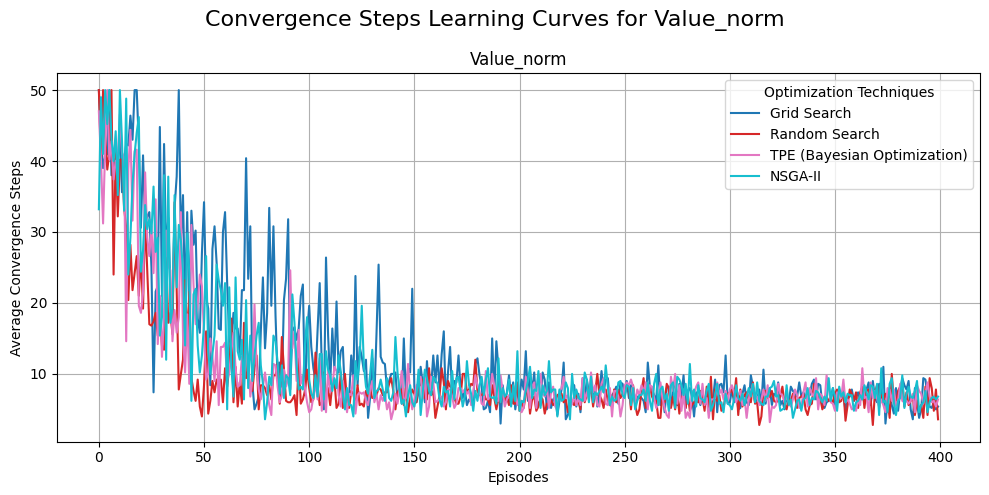

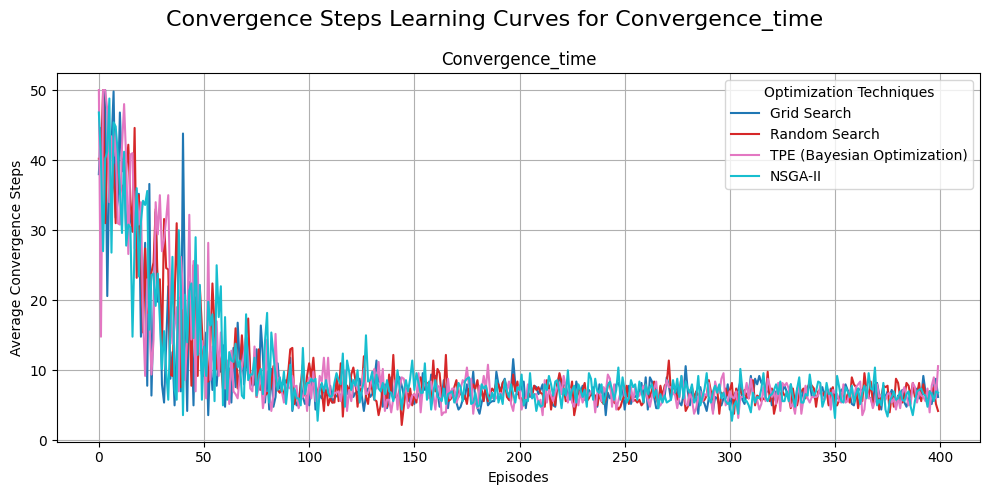

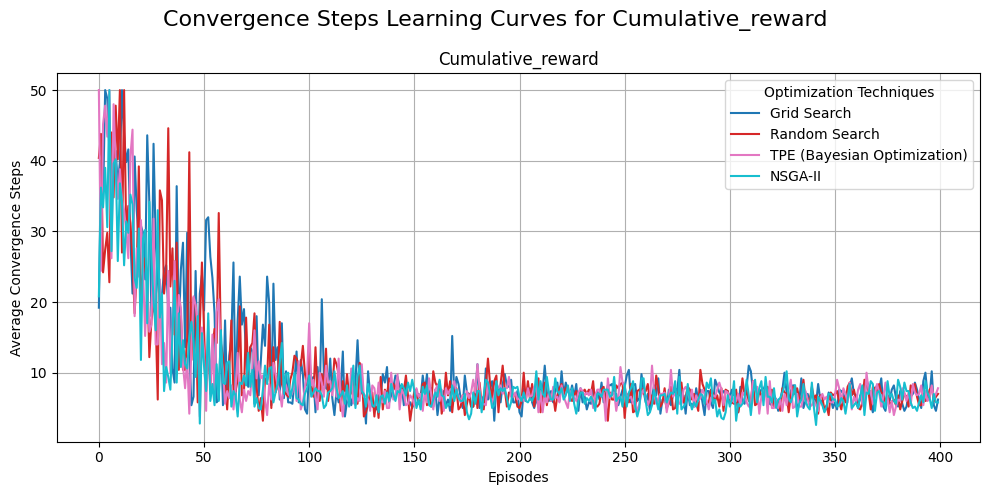

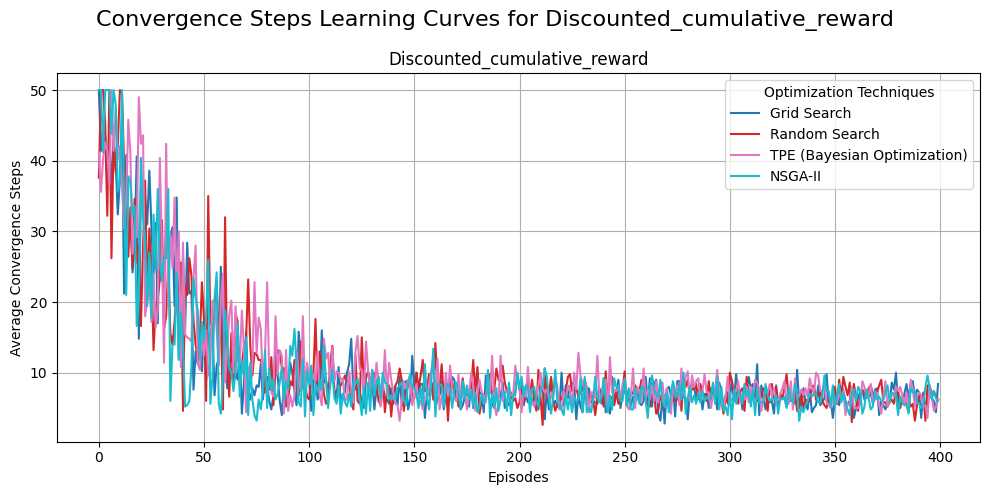

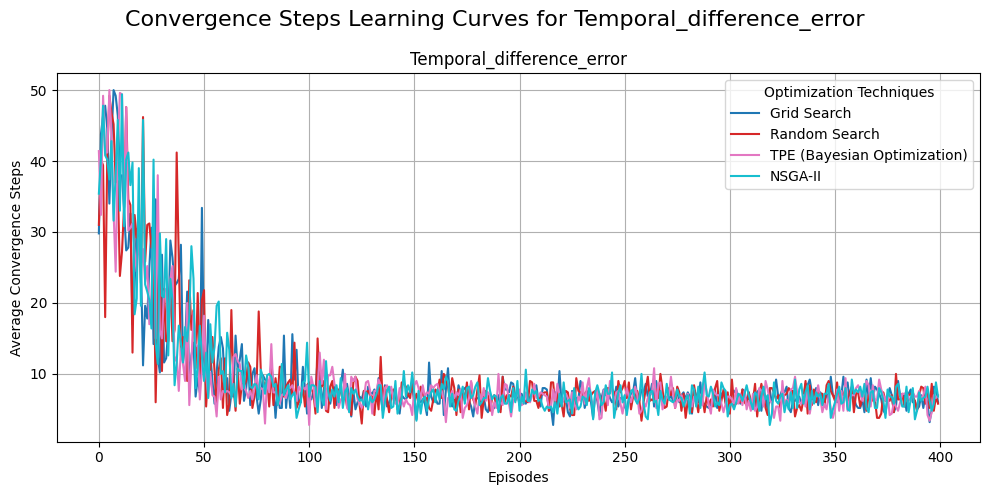

In [33]:
%matplotlib inline
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Convergence Steps", compute_convergence_steps)


### Mean Values Learing Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


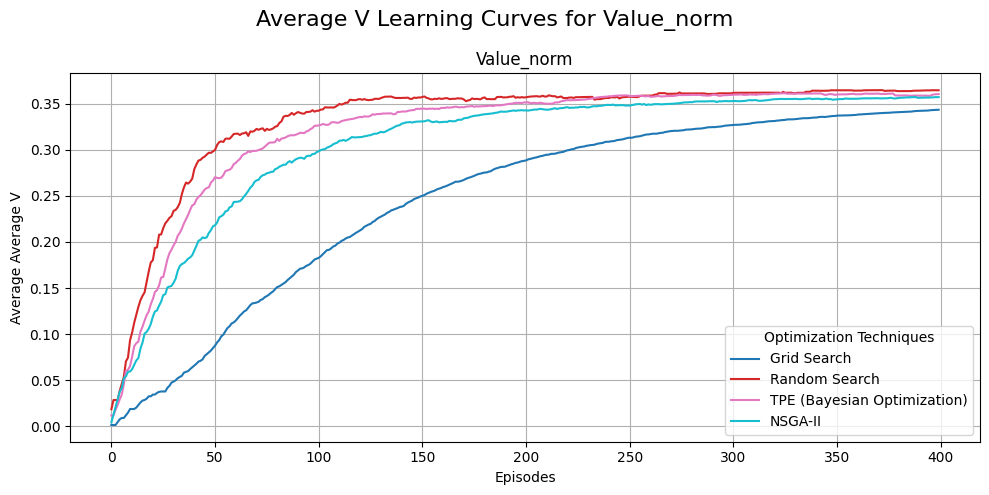

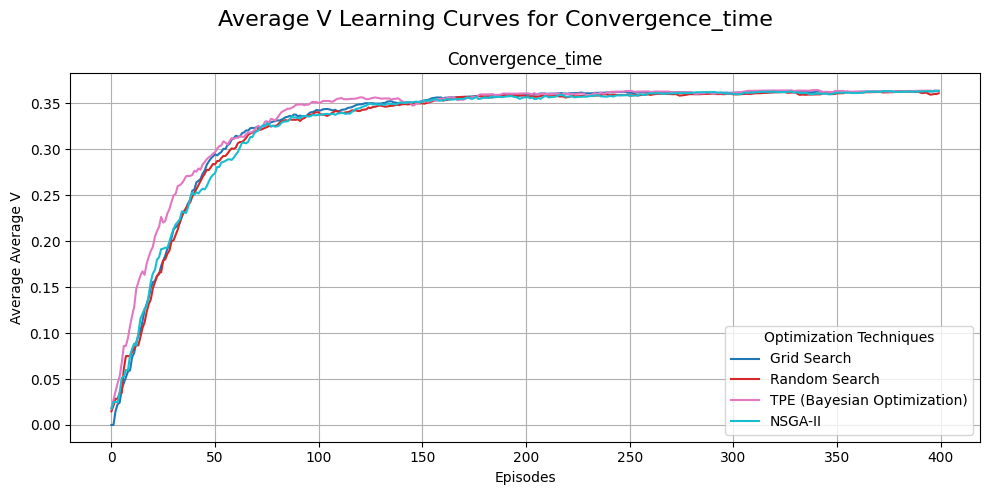

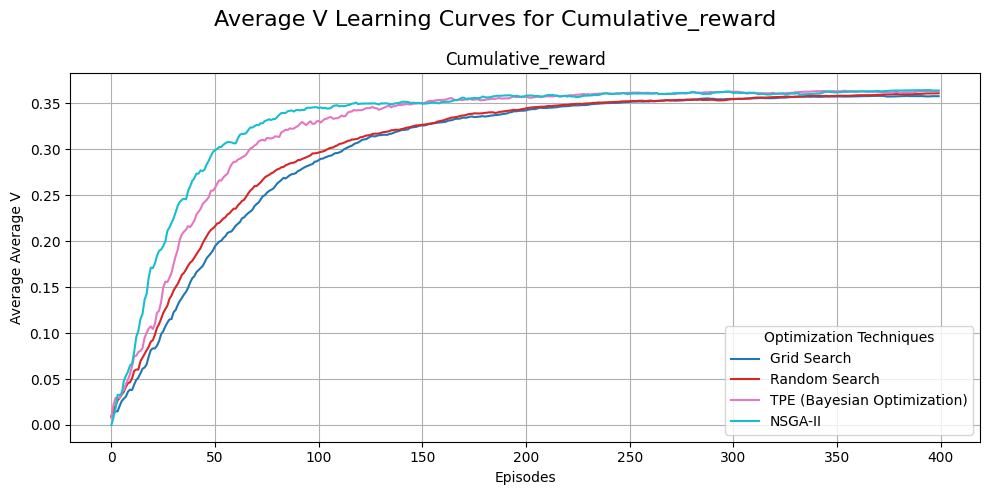

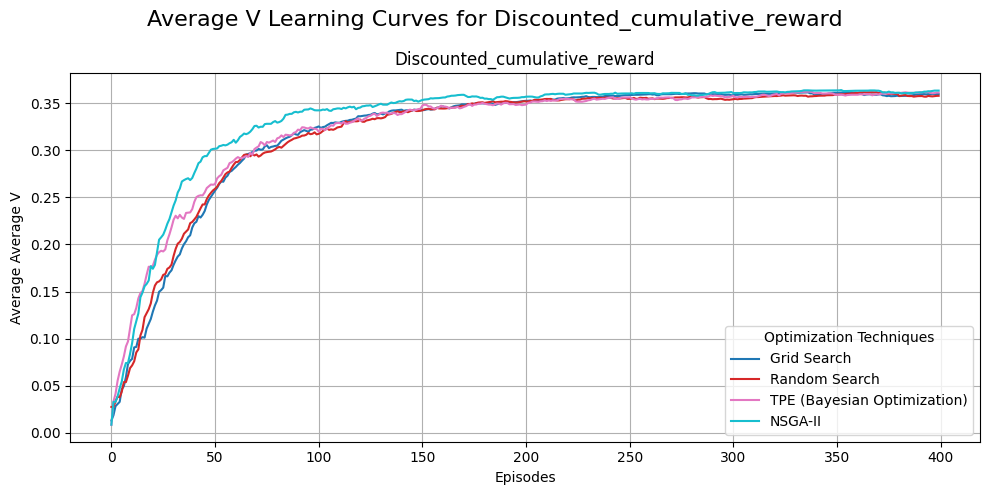

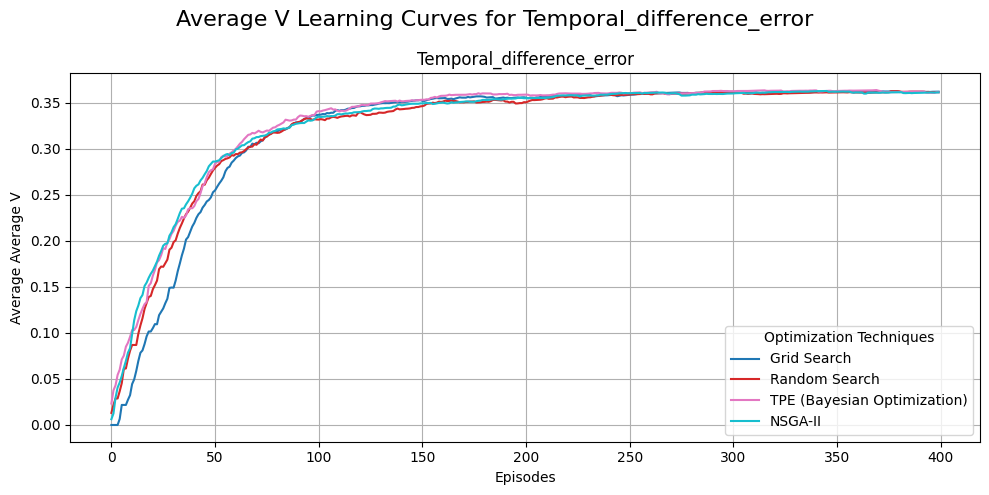

In [34]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Average V", compute_avg_values)


### Rewards Learning Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


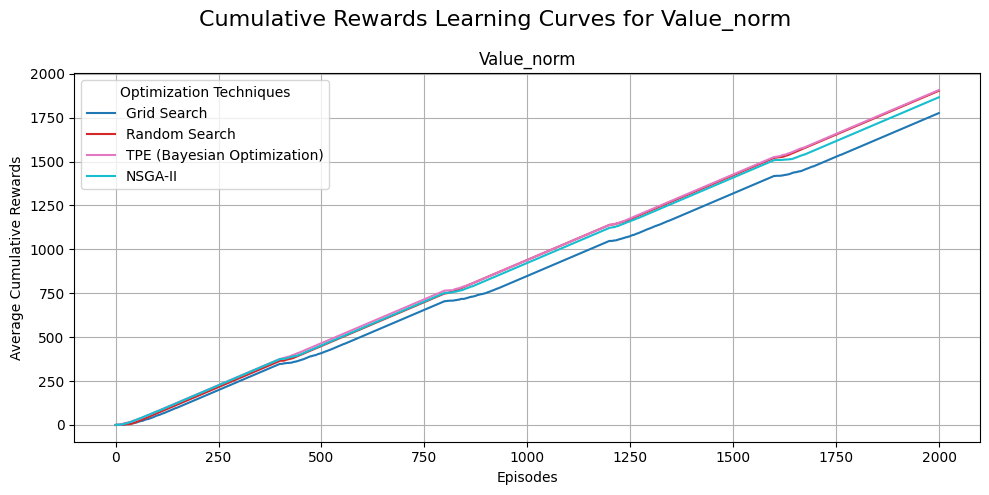

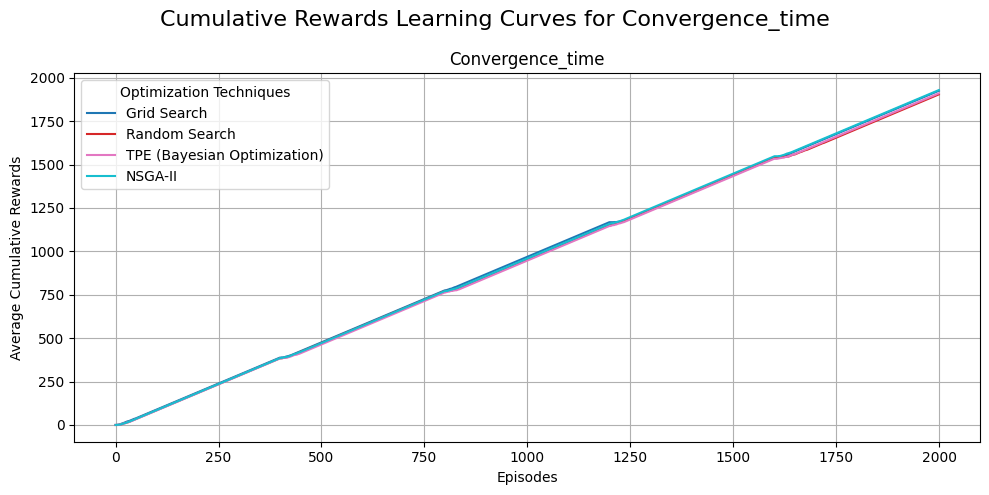

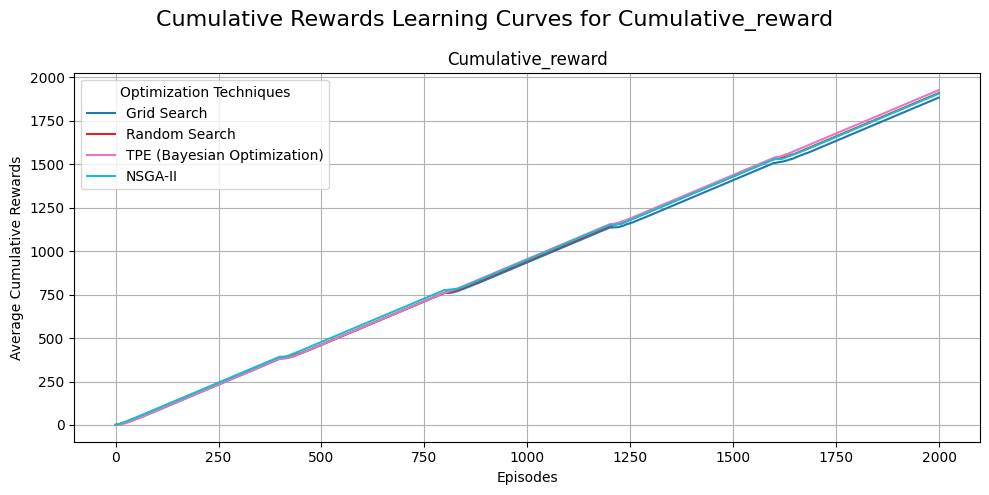

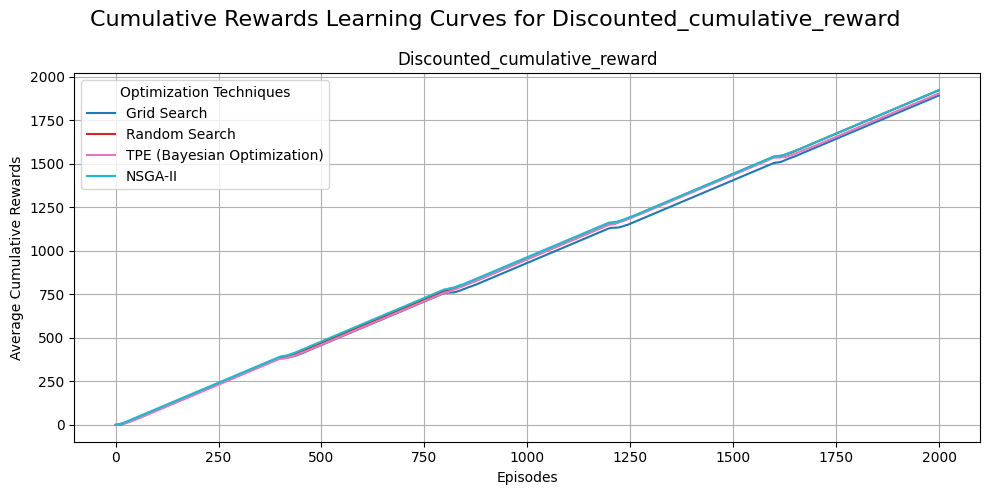

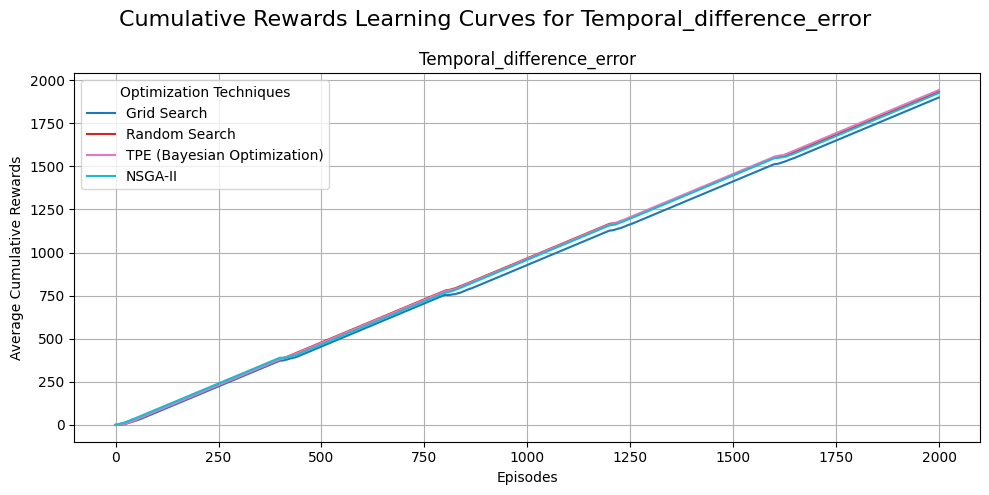

In [35]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Cumulative Rewards", compute_cumulative_rewards)


/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


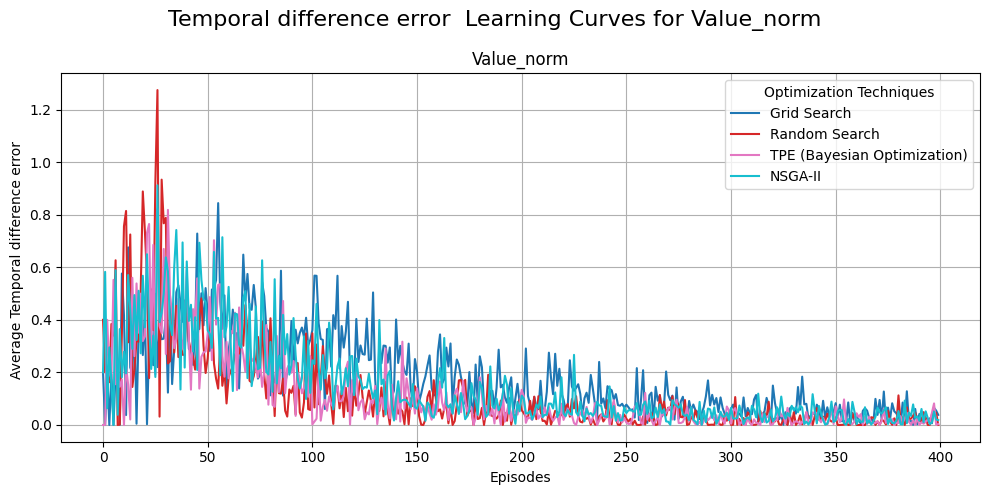

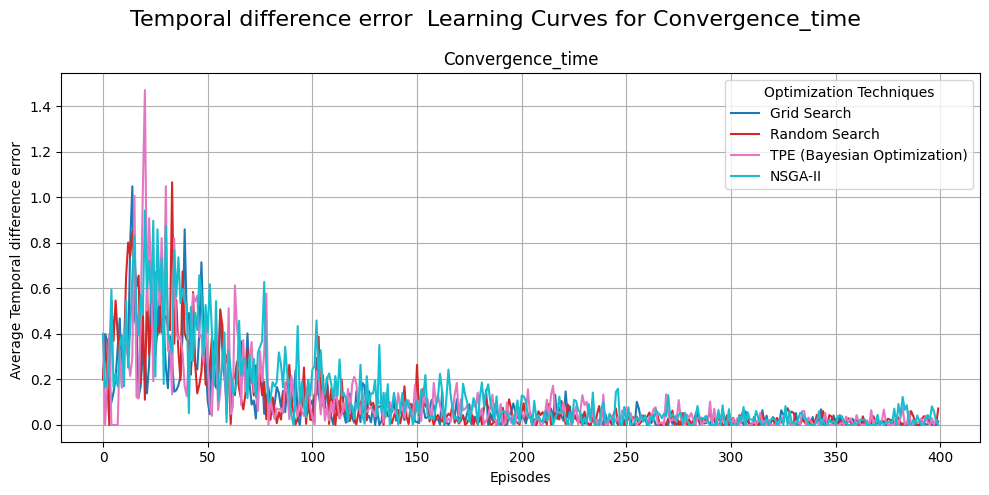

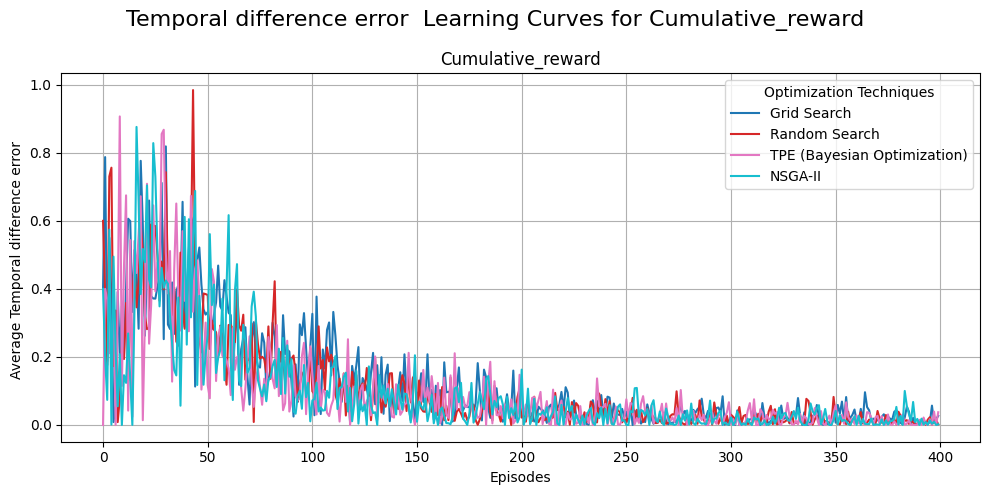

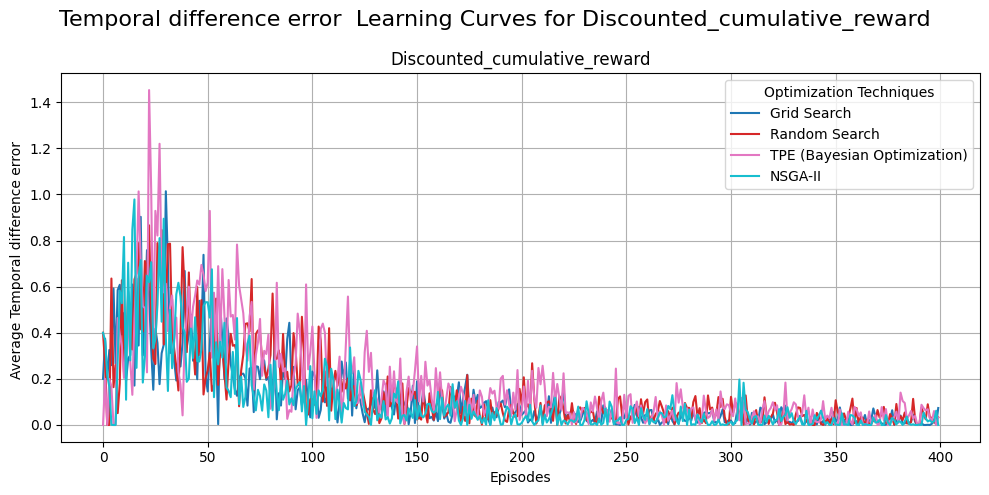

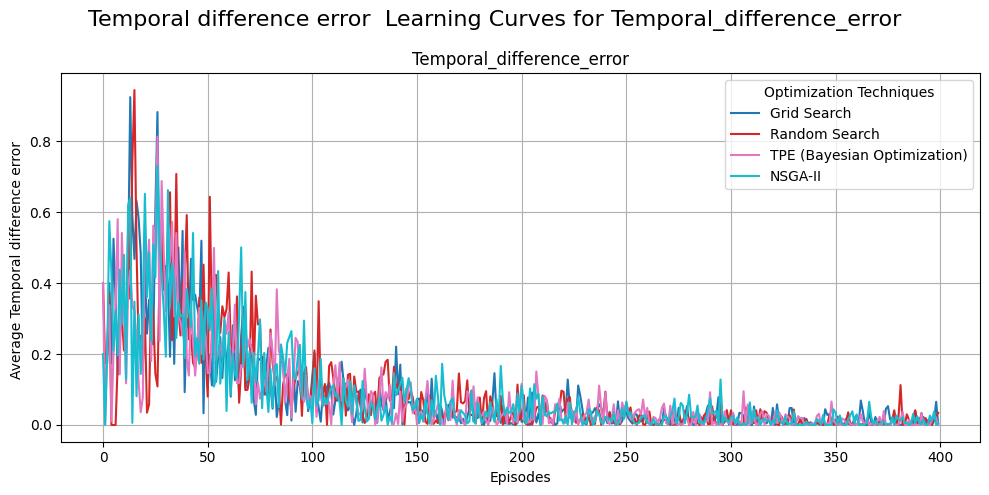

In [36]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Temporal difference error ", compute_deltas)


## The heat maps

### Value norms

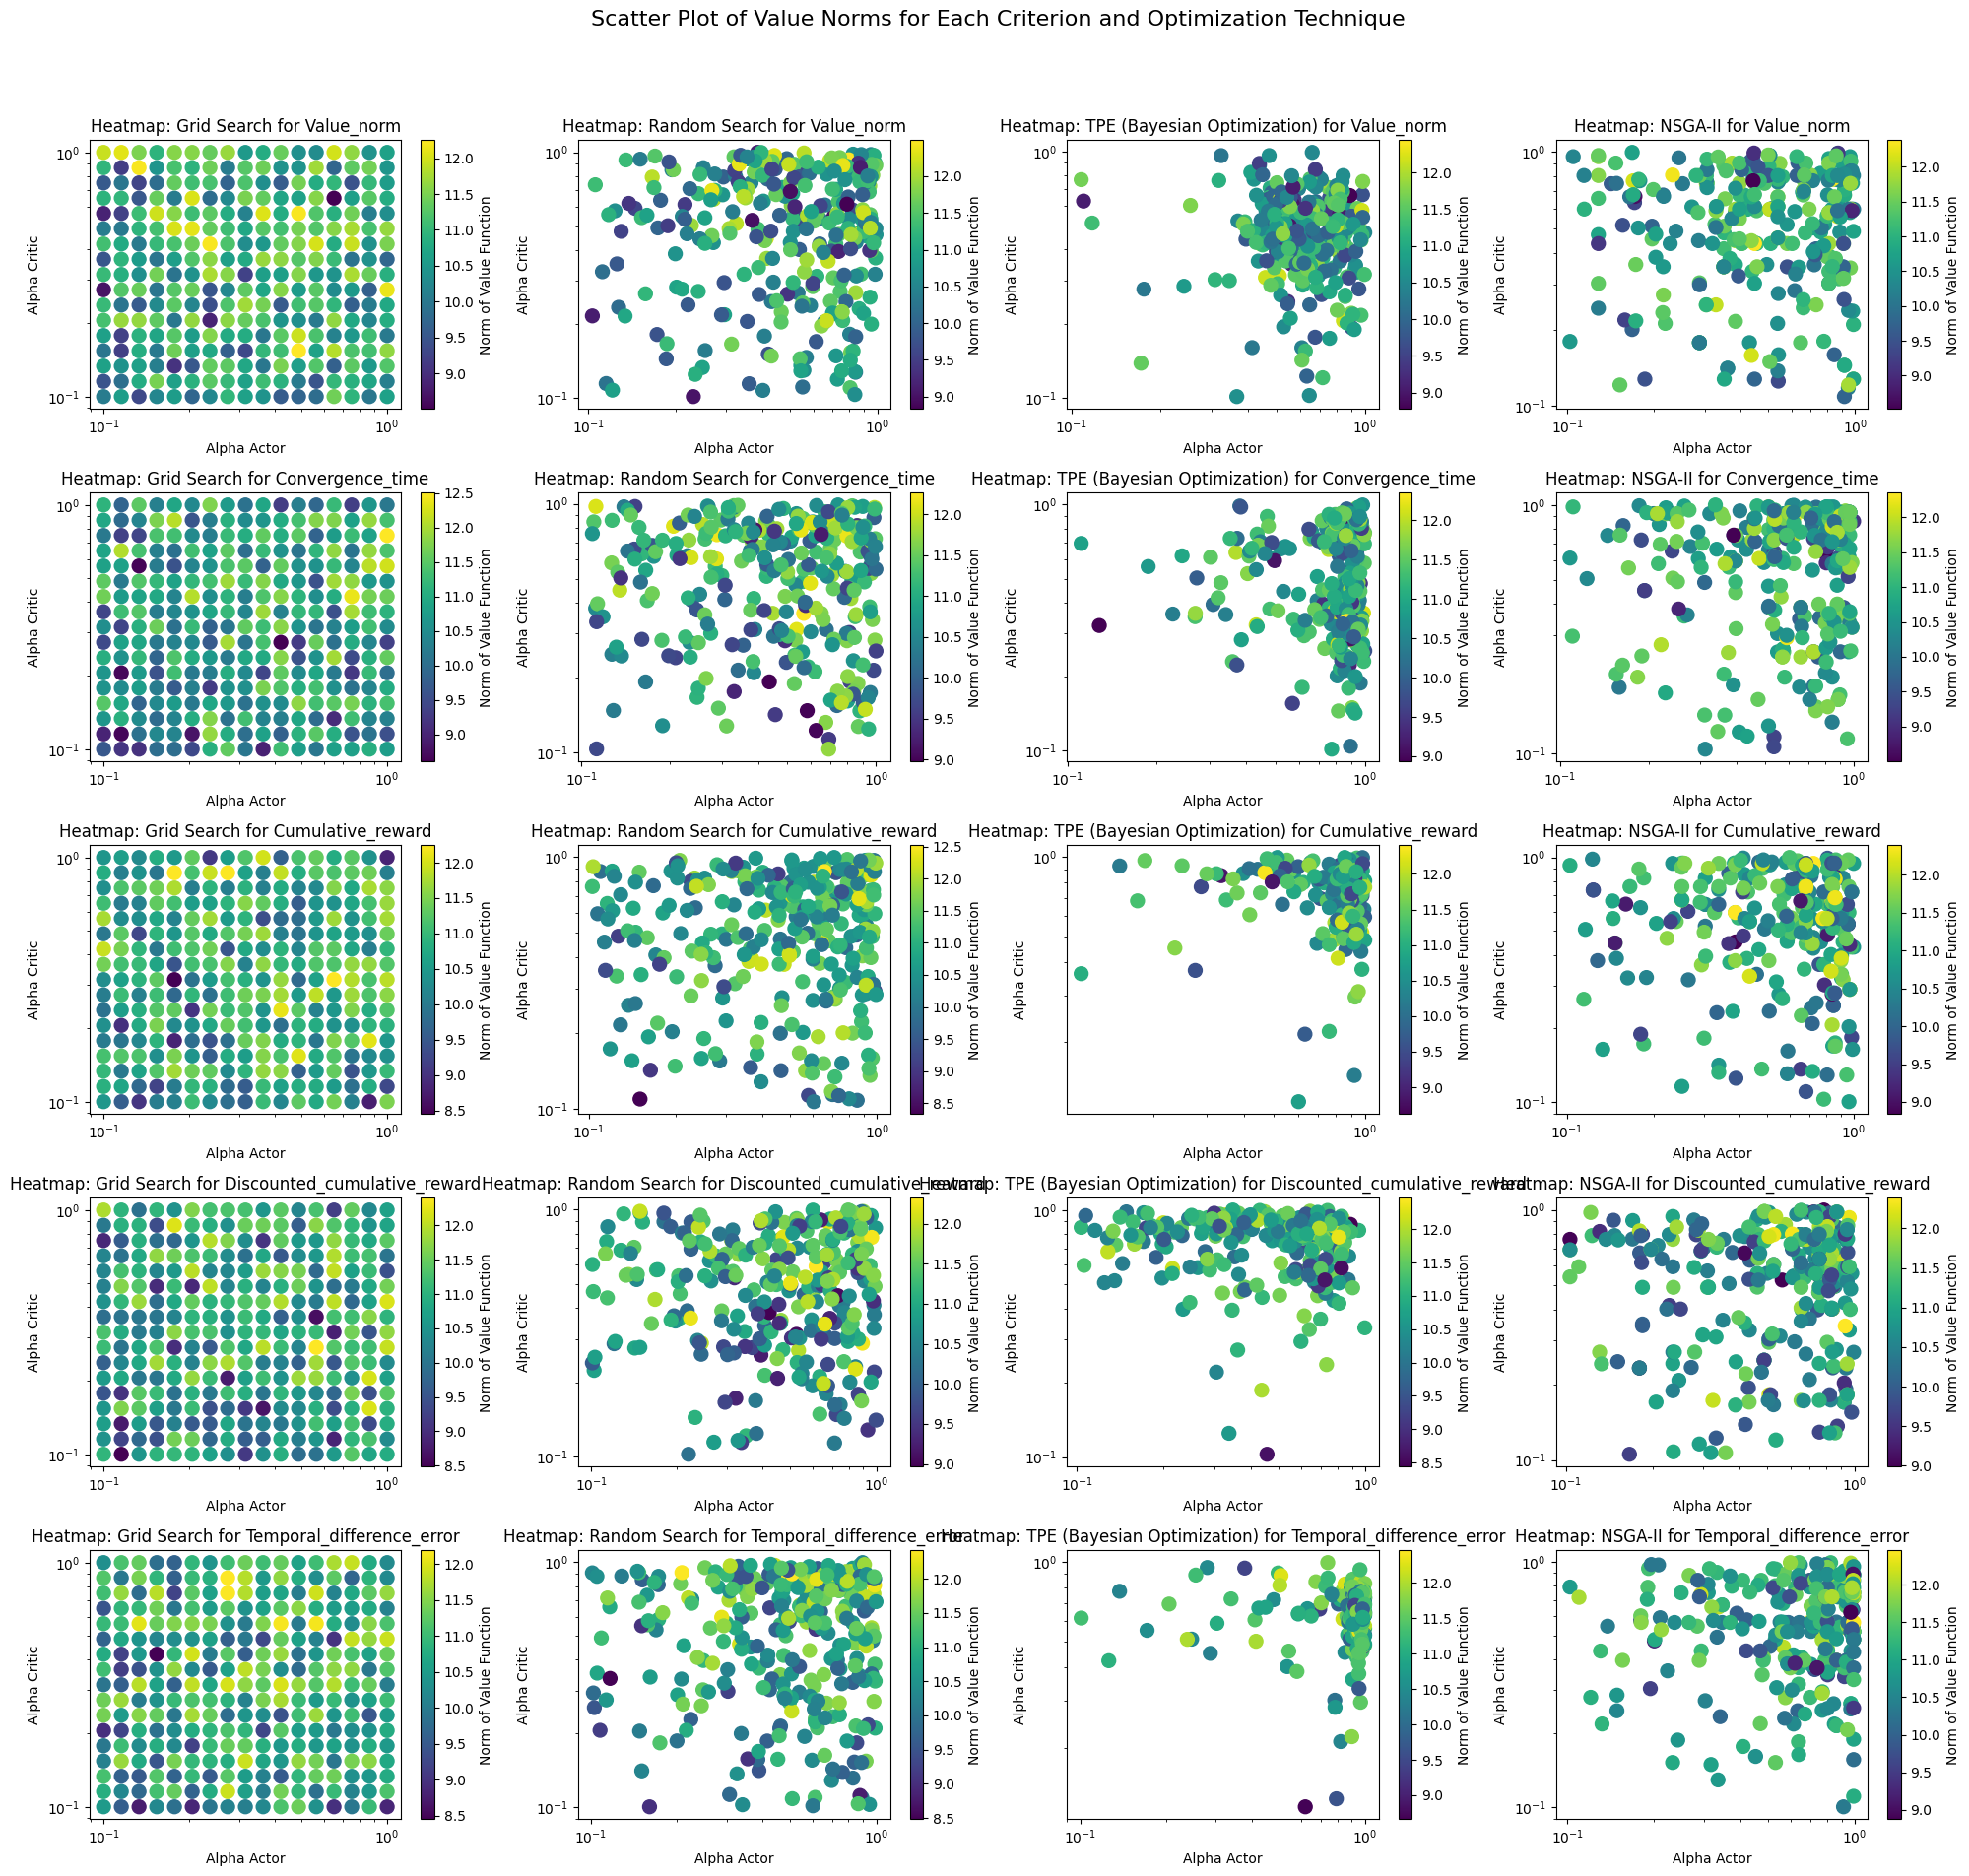

In [37]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Value Norms for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding value norms
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        value_norms = result['value_norms']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=value_norms, cmap='viridis', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Heatmap: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the value norms
        fig.colorbar(scatter, ax=ax, label='Norm of Value Function')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### The Cumulative Rewards

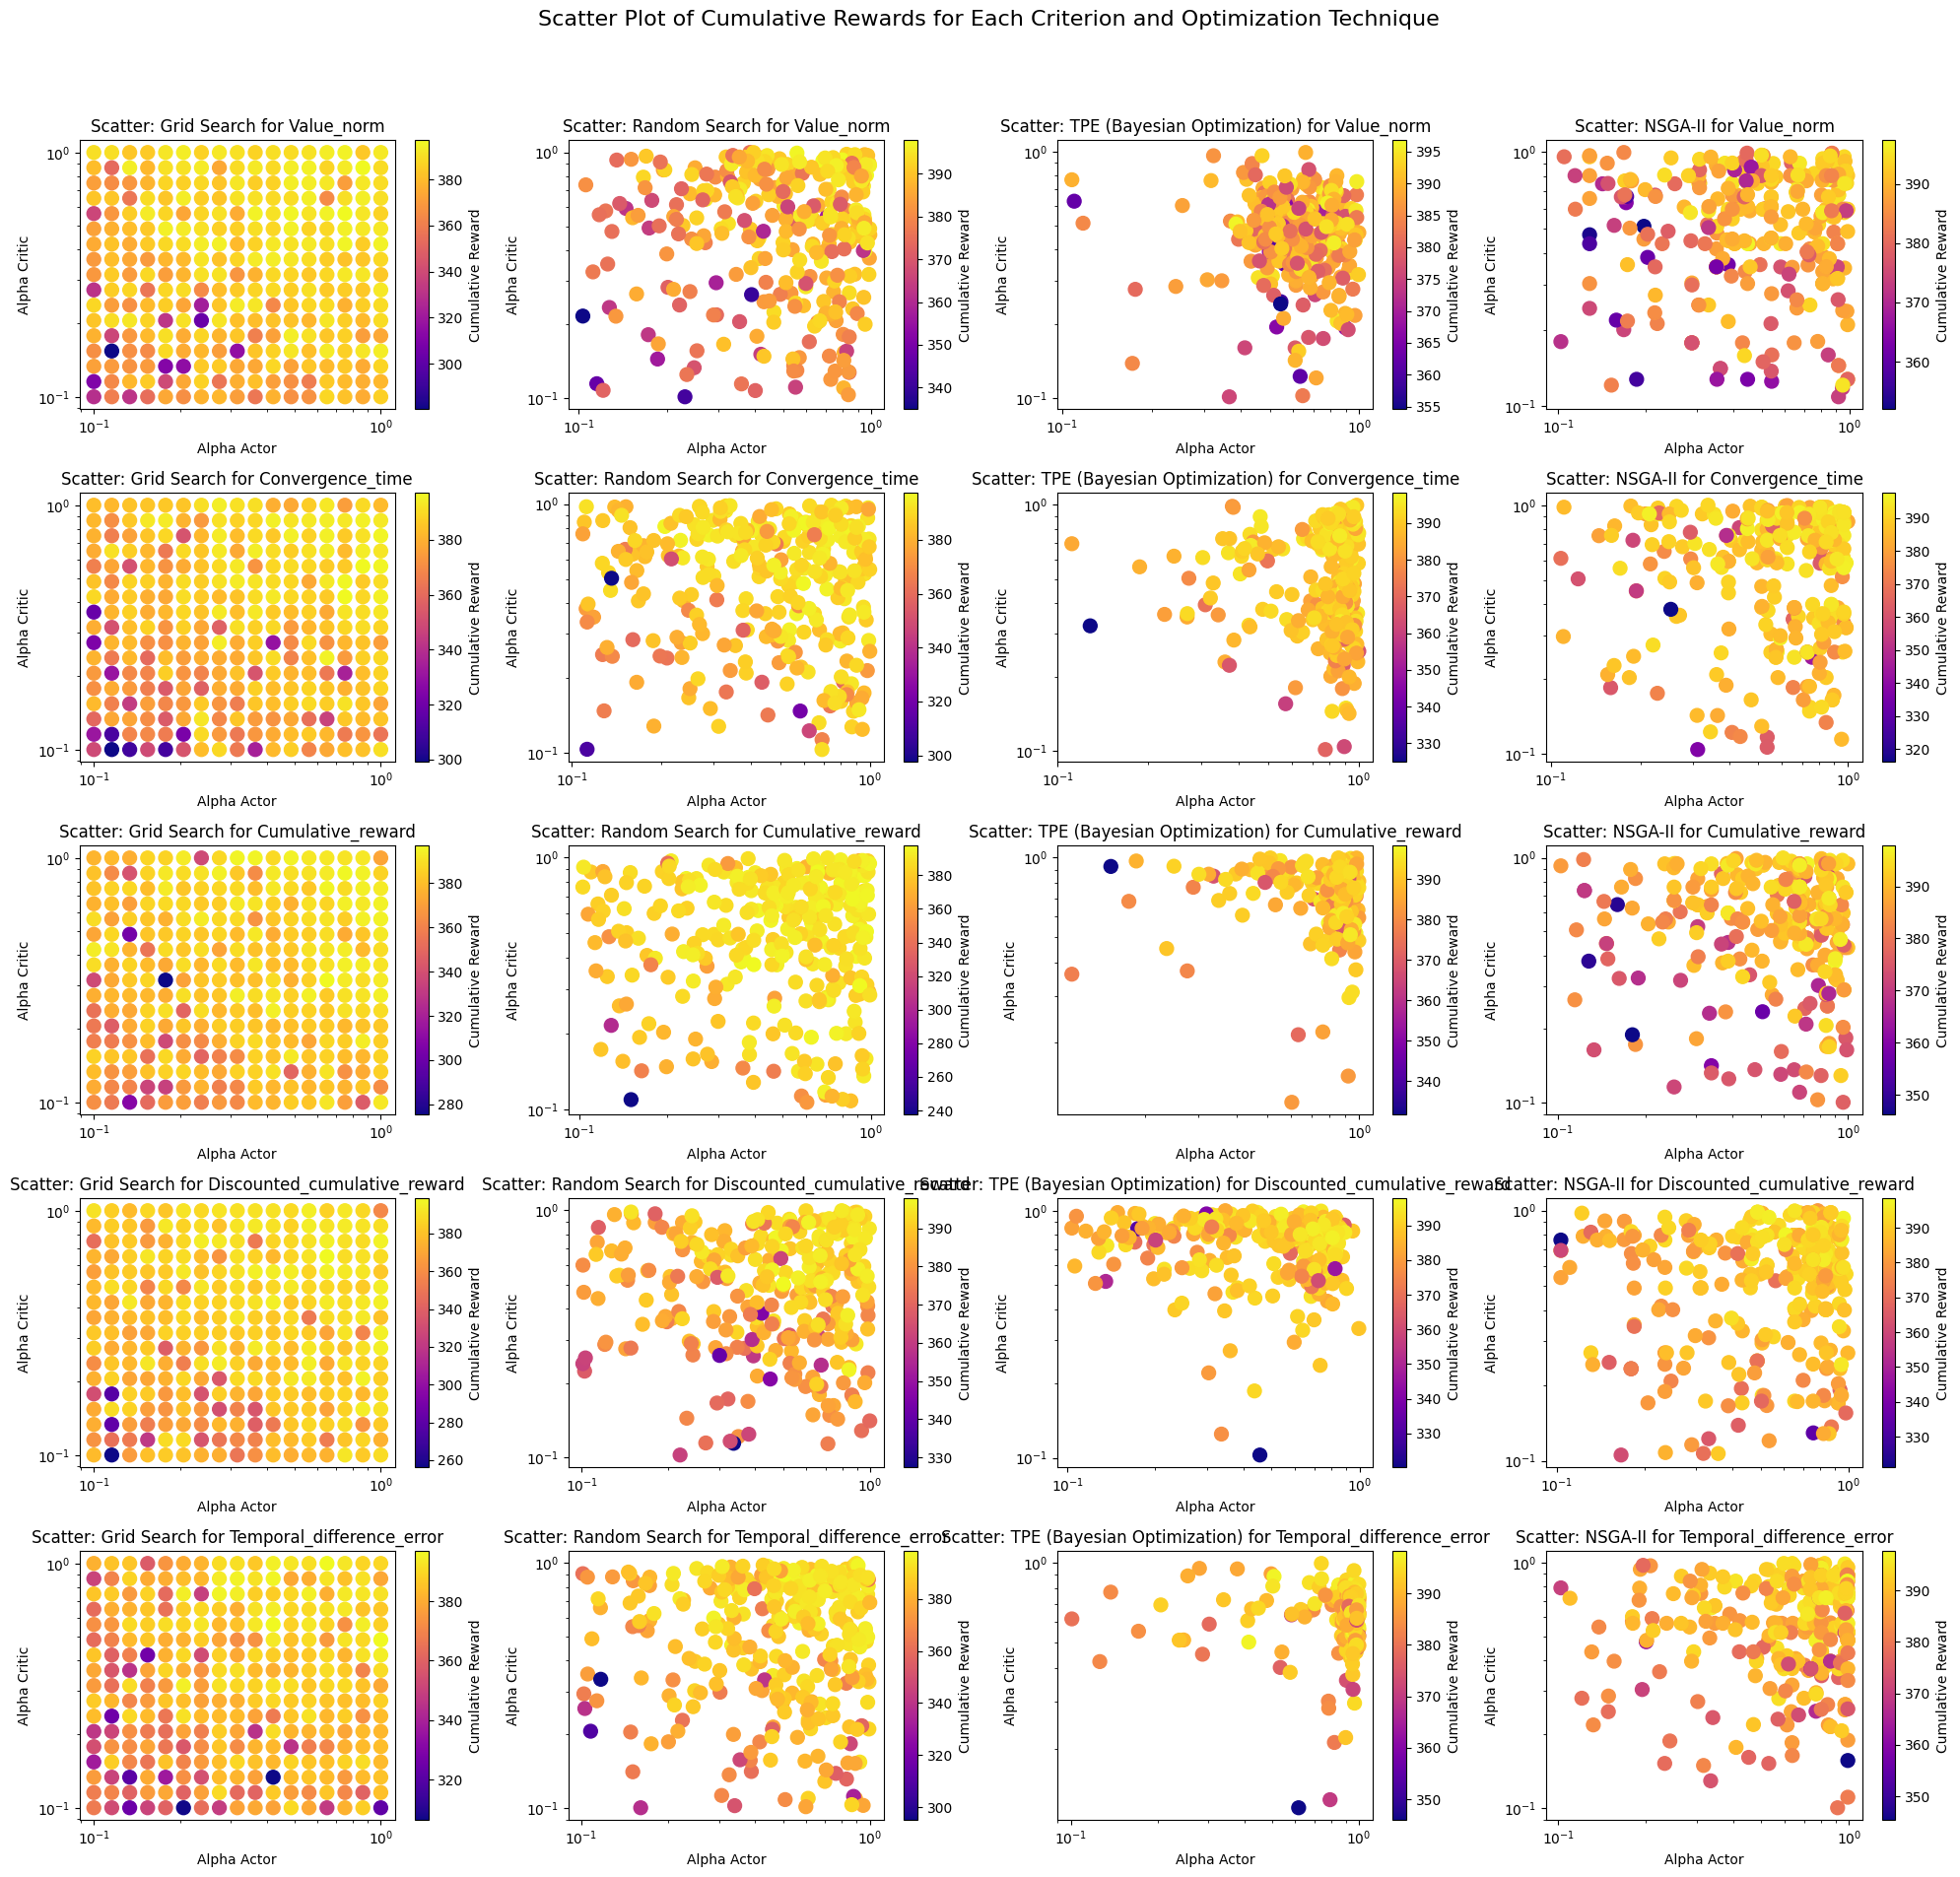

In [38]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Cumulative Rewards for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding cumulative rewards
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        cumulative_rewards = result['cumulative_rewards']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot for cumulative rewards
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=cumulative_rewards, cmap='plasma', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Scatter: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the cumulative rewards
        fig.colorbar(scatter, ax=ax, label='Cumulative Reward')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()
